<a href="https://colab.research.google.com/github/hyemin3656/Bert_classification_model/blob/main/tradename_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://yonghee.io/bert_binary_classification_naver/





In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 103.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 125.8 MB/s eta 0:00:00


In [ ]:
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

In [ ]:
import os

n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

1
Tesla T4


In [ ]:
data = pd.read_csv('/content/sample_data/redata.csv')

print(data.shape)

print(len(data.loc[data['label'] == 0]))
print(len(data.loc[data['label'] == 1]))
print(len(data.loc[data['label'] == 2]))

print(data)


(5093, 3)
2136
880
2077
      Unnamed: 0         상호명  label
0              0    뉴욕핫도그 치킨      0
1              1    백중기와야순두부      0
2              2         문삼이      0
3              3      어부의 밥상      0
4              4         두울원      0
...          ...         ...    ...
5088        8275     조선생수학학원      2
5089        8276     조선생에듀학원      2
5090        8277     주연수학교습소      2
5091        8278  즐거운스즈키음악학원      2
5092        8279    지앤지수학교습소      2

[5093 rows x 3 columns]


In [ ]:
document_bert = ["[CLS] " + str(s) + " [SEP]" for s in data['상호명']]
document_bert[:5]

['[CLS] 뉴욕핫도그 치킨 [SEP]',
 '[CLS] 백중기와야순두부 [SEP]',
 '[CLS] 문삼이 [SEP]',
 '[CLS] 어부의 밥상 [SEP]',
 '[CLS] 두울원 [SEP]']

In [ ]:
def print_class_num(df, label_name):            # 이진 클래스의 비율을 알아보기 위한 함수
  n_total = len(df)                             # 데이터의 총 개수
  n_1 = len(df.query(label_name + ' == 0'))   # label로 사용하는 열의 1 개수
  n_2 = len(df.query(label_name + ' == 1'))   # label로 사용하는 열의 0 개수
  n_3 = len(df.query(label_name + ' == 2'))
  print("식비: {}개, {:.2f}%".format(n_1, n_1*100/n_total))
  print("마트/편의점: {}개, {:.2f}%".format(n_2, n_2*100/n_total))
  print("교육: {}개, {:.2f}%\n".format(n_3, n_3*100/n_total))

  values = df[label_name].value_counts()        # label로 사용하는 열의 값을 카운트
  values.plot(kind='bar')
  print(values)

식비: 2136개, 41.94%
마트/편의점: 880개, 17.28%
교육: 2077개, 40.78%

0    2136
2    2077
1     880
Name: label, dtype: int64


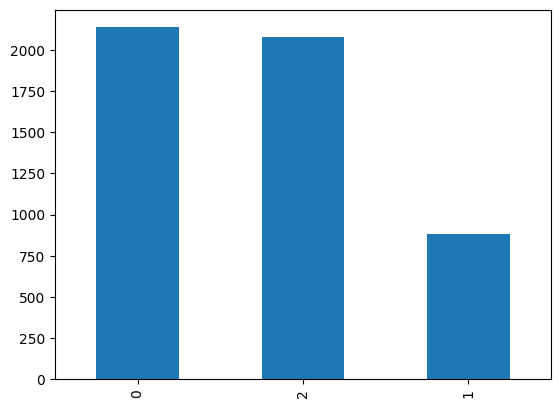

In [ ]:
print_class_num(data, 'label')

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(s) for s in document_bert]
print(tokenized_texts[0])

['[CLS]', '뉴', '##욕', '##핫', '##도', '##그', '치', '##킨', '[SEP]']


In [ ]:
print(tokenizer.tokenize('이디야커피'))

['이', '##디', '##야', '##커', '##피']


In [ ]:
max_len =0
for i in tokenized_texts:
  if max_len < len(i):
    max_len = len(i)
print(max_len)

32


In [ ]:
MAX_LEN = 32
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')
input_ids[0]

array([   101,   9039, 109971, 119419,  12092,  78136,   9779, 119330,
          102,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0])

In [ ]:
attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
#train, test 나누기
x_train, x_test, y_train, y_test, mask_train, mask_test = train_test_split(input_ids, data['label'].values, attention_masks, test_size=0.2, random_state=42, stratify = data['label'])
print("x_train: {}개,\ty_train: {}개".format(len(x_train), len(y_train)))
print("x_test: {}개,\ty_test: {}개".format(len(x_test), len(y_test)))
print("mask_train: {}개,\tmask_test: {}개".format(len(mask_train), len(mask_test)))


x_train: 4074개,	y_train: 4074개
x_test: 1019개,	y_test: 1019개
mask_train: 4074개,	mask_test: 1019개


In [ ]:
x_train, x_valid, y_train, y_valid, mask_train, mask_valid = train_test_split(x_train, y_train, mask_train, test_size=0.2, random_state=42, stratify = y_train)
print("x_train: {}개,\ty_train: {}개".format(len(x_train), len(y_train)))
print("x_valid: {}개,\ty_valid: {}개".format(len(x_valid), len(y_valid)))
print("mask_train: {}개,\tmask_valid: {}개".format(len(mask_train), len(mask_valid)))


x_train: 3259개,	y_train: 3259개
x_valid: 815개,	y_valid: 815개
mask_train: 3259개,	mask_valid: 815개


In [ ]:
#데이터 불균형 처리
y_train = pd.DataFrame(y_train)
x_train = pd.DataFrame(x_train)
mask_train = pd.DataFrame(mask_train)

xm_train = pd.concat([x_train, mask_train], axis=1)

y_t = np.array(y_train)

xm_train['label'] = y_t
nn1_train = xm_train[xm_train['label'] == 1]
nn2_train = xm_train[xm_train['label'] == 2]

nn1_train = nn1_train.reset_index(drop = True)
nn2_train = nn2_train.reset_index(drop = True)
print(nn1_train)

       0      1       2       3       4       5      6      7      8      9  \
0    101   9435   46520   22200   33188   14871  11287    102      0      0   
1    101   9414   16985   23811   15184     102      0      0      0      0   
2    101   9689   21155   14863   12945    9638  23811  15184    102      0   
3    101   9993   12424   14040   13890     102      0      0      0      0   
4    101  10117   21318   14703     102       0      0      0      0      0   
..   ...    ...     ...     ...     ...     ...    ...    ...    ...    ...   
558  101   9434  105462   42815   43022   14040  18227    142  21572    102   
559  101  70069   69168     102       0       0      0      0      0      0   
560  101   9469   24891   92688   10739  118663    102      0      0      0   
561  101   9706   10530   12605   69168   18392  21386  13890  50632  11261   
562  101   9208   28911  119060  119418    9208  28911  14040  77884  23811   

     ...   23   24   25   26   27   28   29   30   

In [ ]:
print(y_t)

[[0]
 [1]
 [2]
 ...
 [1]
 [0]
 [0]]


In [ ]:
#RD
import random
rd1_train = nn1_train.copy()
rand_num = random.randint(1, 31)

for i in range(len(rd1_train)):
  if(int(rd1_train.iloc[i, rand_num]) != 0 and int(rd1_train.iloc[i, rand_num]) != 102):
    rd1_train.iloc[i, rand_num] = 103
  else:
    while(int(rd1_train.iloc[i, rand_num]) == 0 or int(rd1_train.iloc[i, rand_num]) == 102):
      rand_num = random.randint(1,31)
      if(int(rd1_train.iloc[i, rand_num]) != 0 and int(rd1_train.iloc[i, rand_num]) != 102):
        rd1_train.iloc[i, rand_num] = 103
  rand_num = random.randint(1,31)

# row 생략 없이 출력
pd.set_option('display.max_rows', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None)

print(rd1_train)

       0       1       2       3       4       5       6       7       8  \
0    101    9435     103   22200   33188   14871   11287     102       0   
1    101     103   16985   23811   15184     102       0       0       0   
2    101    9689   21155   14863   12945    9638   23811     103     102   
3    101    9993   12424   14040     103     102       0       0       0   
4    101     103   21318   14703     102       0       0       0       0   
5    101    9638   23811   15184     103  119113  118649   16758  119152   
6    101    9928   14040     103     102       0       0       0       0   
7    101    9521   37114   41693  119119   14040     103     102       0   
8    101   70069     103  118758  118649   16323   18623   27355     102   
9    101    8903   16758     103   43022   14040   13890     102       0   
10   101    9954   18227     103   30873   31065     102       0       0   
11   101    9410  119409     103   17342   13764     102       0       0   
12   101   7

In [ ]:
#RS
"""
c = 0
rs_train = nn1_train.copy()

rand_1 = random.randint(1, 8)
rand_2 = rand_1
while rand_2 == rand_1:
  rand_2 = random.randint(1, 8)

for i in range(len(rs_train)):
  n_arr =[]
  for a in rs_train.loc[i]:
    if a != 0 and a!= 0.0 and a!= 0.1 and a != 1:
      n_arr.append(a)
  if len(n_arr) == 3:
    continue
  if (int(rs_train.iloc[i, rand_1]) != 0 and int(rs_train.iloc[i, rand_1]) != 102 and int(rs_train.iloc[i, rand_2]) != 0 and int(rs_train.iloc[i, rand_2]) != 102):
    rs_train.iloc[i, rand_1], rs_train.iloc[i, rand_2] = rs_train.iloc[i, rand_2], rs_train.iloc[i, rand_1]
    print(c)
    c+=1

  else:
    while(int(rs_train.iloc[i, rand_1]) == 0 or int(rs_train.iloc[i, rand_1]) == 102 or int(rs_train.iloc[i, rand_2]) == 0 or int(rs_train.iloc[i, rand_2]) == 102):
      rand_1 = random.randint(1, 8)
      rand_2 = rand_1
      while rand_2 == rand_1:
        rand_2 = random.randint(1,8)
      if (int(rs_train.iloc[i, rand_1]) != 0 and int(rs_train.iloc[i, rand_1]) != 102 and int(rs_train.iloc[i, rand_2]) != 0 and int(rs_train.iloc[i, rand_2]) != 102):
        print(c)
        c +=1
        rs_train.iloc[i, rand_1], rs_train.iloc[i, rand_2] = rs_train.iloc[i, rand_2], rs_train.iloc[i, rand_1]
        break
  rand_1 = random.randint(1,8)
  rand_2 = rand_1
  while rand_2 == rand_1:
    rand_2 = random.randint(1,8)
print(rs_train)
"""

'\nc = 0\nrs_train = nn1_train.copy()\n\nrand_1 = random.randint(1, 8)\nrand_2 = rand_1\nwhile rand_2 == rand_1:\n  rand_2 = random.randint(1, 8)\n\nfor i in range(len(rs_train)):\n  n_arr =[]\n  for a in rs_train.loc[i]:\n    if a != 0 and a!= 0.0 and a!= 0.1 and a != 1:\n      n_arr.append(a)\n  if len(n_arr) == 3:\n    continue\n  if (int(rs_train.iloc[i, rand_1]) != 0 and int(rs_train.iloc[i, rand_1]) != 102 and int(rs_train.iloc[i, rand_2]) != 0 and int(rs_train.iloc[i, rand_2]) != 102):\n    rs_train.iloc[i, rand_1], rs_train.iloc[i, rand_2] = rs_train.iloc[i, rand_2], rs_train.iloc[i, rand_1]\n    print(c)\n    c+=1\n\n  else:\n    while(int(rs_train.iloc[i, rand_1]) == 0 or int(rs_train.iloc[i, rand_1]) == 102 or int(rs_train.iloc[i, rand_2]) == 0 or int(rs_train.iloc[i, rand_2]) == 102):\n      rand_1 = random.randint(1, 8)\n      rand_2 = rand_1\n      while rand_2 == rand_1:\n        rand_2 = random.randint(1,8)\n      if (int(rs_train.iloc[i, rand_1]) != 0 and int(rs_train.

In [ ]:
#레이블 1인 데이터 합치기
result_train1 = pd.concat([nn1_train,rd1_train], ignore_index=True)

print(result_train1)

        0       1       2       3       4       5       6       7       8  \
0     101    9435   46520   22200   33188   14871   11287     102       0   
1     101    9414   16985   23811   15184     102       0       0       0   
2     101    9689   21155   14863   12945    9638   23811   15184     102   
3     101    9993   12424   14040   13890     102       0       0       0   
4     101   10117   21318   14703     102       0       0       0       0   
5     101    9638   23811   15184   53398  119113  118649   16758  119152   
6     101    9928   14040  119227     102       0       0       0       0   
7     101    9521   37114   41693  119119   14040   13890     102       0   
8     101   70069   69168  118758  118649   16323   18623   27355     102   
9     101    8903   16758   16617   43022   14040   13890     102       0   
10    101    9954   18227  118618   30873   31065     102       0       0   
11    101    9410  119409   28396   17342   13764     102       0       0   

0    1367
2    1329
1    1126
Name: label, dtype: int64


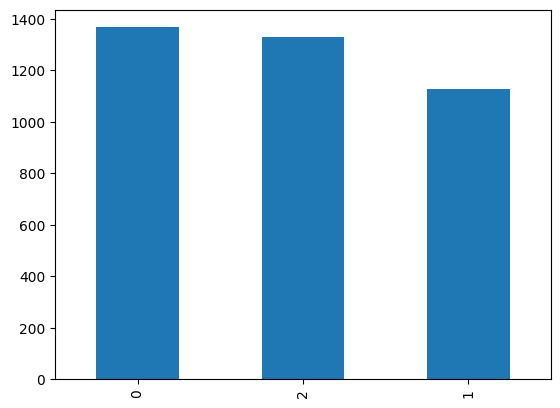

In [ ]:


#label 1, 2 합치기
result0_train = xm_train[xm_train['label'] == 0]
result0_train = result0_train.reset_index(drop = True)
result12_train = pd.concat([result_train1,nn2_train], ignore_index=True)
result_train = pd.concat([result0_train,result12_train], ignore_index=True)

values = result_train['label'].value_counts()
values.plot(kind='bar')
print(values)

In [ ]:
print(result_train)

        0       1       2       3       4       5       6       7       8  \
0     101    9786  119391   17342   12692     102       0       0       0   
1     101     100     102       0       0       0       0       0       0   
2     101    9638  119025   26444   34994     102       0       0       0   
3     101     100     102       0       0       0       0       0       0   
4     101     100    9779   24891    9901   12605   22695     102       0   
5     101    9690   28396  118873   24891     102       0       0       0   
6     101    9519  118828     102       0       0       0       0       0   
7     101    9727   21789   28000   42337     102       0       0       0   
8     101    9625   13890   97707  118773   21789   13890     102       0   
9     101     100     102       0       0       0       0       0       0   
10    101    9543   68055   13890   83467     123     102       0       0   
11    101     100     102       0       0       0       0       0       0   

In [ ]:
#x, y, mask 로 나누기
x_train_add = []
y_train_add = []
mask_train_add = []
for i in range(len(result_train)):
  x_train_add.append(result_train.iloc[i, 0:32].to_numpy())
  mask_train_add.append(result_train.iloc[i, 32:64].to_numpy())
  y_train_add.append(result_train.loc[i,'label'])

x_train_add = np.asarray(x_train_add,dtype = int)
y_train_add = list(map(int,y_train_add))



In [ ]:
print(x_train_add[2140])
print(y_train_add[2140])
print(mask_train_add[2140])

[   101   9365    103 118746  70122  15891  21386  29364  42815  43022
 119044  22695    102      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0]
1
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
train_inputs = torch.tensor(x_train_add)
train_labels = torch.tensor(y_train_add)
train_masks = torch.tensor(mask_train_add)
validation_inputs = torch.tensor(x_valid)
validation_labels = torch.tensor(y_valid)
validation_masks = torch.tensor(mask_valid)

<ipython-input-24-0366c17a6373>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  train_masks = torch.tensor(mask_train_add)


In [ ]:
BATCH_SIZE = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

In [ ]:
test_inputs = torch.tensor(x_test)
test_labels = torch.tensor(y_test)
test_masks = torch.tensor(mask_test)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 8

# 총 훈련 스텝
total_steps = len(train_dataloader) * epochs

# lr 조금씩 감소시키는 스케줄러
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # 그래디언트 계산 안함
        with torch.no_grad():
            # Forward 수행
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 8 ========
Training...

  Average training loss: 0.12
  Training epcoh took: 0:00:25

Running Validation...
  Accuracy: 0.91
  Validation took: 0:00:02

======== Epoch 2 / 8 ========
Training...

  Average training loss: 0.09
  Training epcoh took: 0:00:26

Running Validation...
  Accuracy: 0.89
  Validation took: 0:00:02

======== Epoch 3 / 8 ========
Training...

  Average training loss: 0.06
  Training epcoh took: 0:00:26

Running Validation...
  Accuracy: 0.93
  Validation took: 0:00:02

======== Epoch 4 / 8 ========
Training...

  Average training loss: 0.05
  Training epcoh took: 0:00:25

Running Validation...
  Accuracy: 0.93
  Validation took: 0:00:02

======== Epoch 5 / 8 ========
Training...

  Average training loss: 0.05
  Training epcoh took: 0:00:26

Running Validation...
  Accuracy: 0.93
  Validation took: 0:00:02

======== Epoch 6 / 8 ========
Training...

  Average training loss: 0.05
  Training epcoh took: 0:00:26

Running Validation...
  Accuracy: 

In [ ]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch

    # 그래디언트 계산 안함
    with torch.no_grad():
        # Forward 수행
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    print(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

[[-3.0528052   6.2009273  -2.720786  ]
 [ 5.2804065  -2.7183747  -3.004805  ]
 [-2.8662004  -3.3360822   5.9080644 ]
 [ 5.3359723  -2.836573   -2.9782639 ]
 [-2.8776748  -3.3547416   5.905289  ]
 [-2.9296021   6.2278357  -2.8445778 ]
 [-2.8116813  -3.4098165   5.901082  ]
 [ 5.36188    -2.7466302  -3.0642347 ]
 [-2.799263    6.2248096  -3.000019  ]
 [-2.8212352   6.2358932  -2.9336703 ]
 [-2.8586779  -3.3954003   5.906059  ]
 [-2.6598177  -3.454468    5.8627477 ]
 [ 5.2239146  -3.0565434  -2.6540112 ]
 [ 1.4579073  -2.132108   -0.27602416]
 [ 1.4579073  -2.132108   -0.27602416]
 [-2.8427198   6.225778   -2.9437745 ]
 [ 5.3477697  -2.6527655  -3.1024709 ]
 [-2.8472545  -3.4130301   5.895215  ]
 [ 5.292255   -2.7170906  -3.040075  ]
 [-2.9045186  -3.3508315   5.887935  ]
 [ 5.3041306  -2.813522   -2.933076  ]
 [-2.8610513  -3.3869123   5.913115  ]
 [ 5.151076   -3.155767   -2.3871307 ]
 [-2.8812873  -3.3586836   5.901255  ]
 [ 5.3586326  -2.736473   -3.0407076 ]
 [ 5.0690646  -3.1370952 

In [ ]:
# 입력 데이터 변환
def convert_input_data(s):
    """
    import re

    ## (1) [], (), {}, <> 괄호와 괄호 안 문자 제거하기
    pattern = r'\([^)]*\)'  # ()
    s = re.sub(pattern=pattern, repl='', string=s)

    pattern = r'\[[^)]*\]'  # []
    s = re.sub(pattern=pattern, repl='', string=s)

    pattern = r'\<[^)]*\>'  # <>
    s = re.sub(pattern=pattern, repl='', string=s)

    pattern = r'\{[^)]*\}'  # {}
    s = re.sub(pattern=pattern, repl='', string=s)

    ## (2) '...점' 제거하기
    for i in s.split():
      if i.endswith('점'):
        s = s.replace(i, '')
    #s = s.replace('...점', ' ')


    ## (3) 특수문자 제거
    pattern = r'[^a-zA-Z가-힣0-9]'
    s = re.sub(pattern=pattern, repl=' ', string=s)
    """

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in s]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 32

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [ ]:
model.save_pretrained('/content/drive/MyDrive/bert-re')

In [ ]:
# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)

    # 그래디언트 계산 안함
    with torch.no_grad():
        # Forward 수행
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    # 출력 로짓 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [ ]:
logits = test_sentences(['gs25 용현정석점'])

print(logits)
print(np.argmax(logits))

[[-2.2842364  4.556857  -1.9483911]]
1


In [ ]:
logits = test_sentences(['문우당서림'])

print(logits)
print(np.argmax(logits))

[[-2.1679595 -2.5472817  4.6460233]]
2


In [ ]:
logits = test_sentences(['엔젤이너스'])

print(logits)
print(np.argmax(logits))

[[ 2.2038882  -2.3611002  -0.45295015]]
0


In [ ]:
logits = test_sentences([''])

print(logits)
print(np.argmax(logits))

[[-1.879252   4.5033937 -2.405493 ]]
1


In [ ]:
logits = test_sentences(['고망고'])

print(logits)
print(np.argmax(logits))

[[ 0.30857435 -3.4096282   2.800269  ]]
2


In [ ]:
logits = test_sentences(['스타벅스 코리아'])

print(logits)
print(np.argmax(logits))

[[-2.3905141  4.354465  -1.8015875]]
1


In [ ]:
logits = test_sentences(['스타벅스 코리아'])

print(logits)
print(np.argmax(logits))

[[-2.3905141  4.354465  -1.8015875]]
1


In [ ]:
logits = test_sentences(['카페 달록'])

print(logits)
print(np.argmax(logits))

[[ 0.2832353  -0.16080356 -0.07843129]]
0


In [ ]:
logits = test_sentences(['맛있는 치킨'])

print(logits)
print(np.argmax(logits))

[[ 2.7665386 -1.2902117 -2.1727574]]
0


In [ ]:
logits = test_sentences(['후라토식당'])

print(logits)
print(np.argmax(logits))

[[ 0.6964164 -0.4632578 -0.261788 ]]
0


In [ ]:
logits = test_sentences(['이디야 커피'])

print(logits)
print(np.argmax(logits))

[[ 0.47240564 -0.35565048 -0.13909844]]
0


In [ ]:
logits = test_sentences(['영풍문고'])

print(logits)
print(np.argmax(logits))

[[-2.1996918 -2.4944642  4.6763797]]
2


In [ ]:
logits = test_sentences(['교습소'])

print(logits)
print(np.argmax(logits))

[[-1.7180426 -2.8965883  4.3609366]]
2


In [ ]:
logits = test_sentences(['책마루'])

print(logits)
print(np.argmax(logits))

[[ 0.22199467 -0.09803618 -0.06797267]]
0


In [ ]:
logits = test_sentences(['미분당'])

print(logits)
print(np.argmax(logits))

[[ 2.1754174  -2.6634965  -0.27998313]]
0


In [ ]:
logits = test_sentences(['동아리 닭갈비'])

print(logits)
print(np.argmax(logits))

[[ 3.8375075 -2.21556   -2.1905477]]
0
